In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.cbook import flatten
import glob   
import os
import requests

In [30]:
def fitstodat(fitsfile,filename):
  sp=fits.open(fitsfile)
  bintable=sp[1]
  x=bintable.columns['WAVELENGTH']
  y=bintable.columns['FLUX']
  x.name
  x.unit
  xfactor=1
  if x.unit=='nm' :
      xfactor=10.0
  y.name
  y.unit
  yfactor=0
  if (y.unit.split(' ')[0].split('^')[0]=='10') :
    yfactor=float(y.unit.split(' ')[0].split('^')[1])
  yfactor=10**yfactor
  
  W=bintable.data[x.name].T *xfactor
  F=bintable.data[y.name].T *yfactor

  
  concated= np.c_[np.hstack((W[2:-3,])),np.hstack((F[2:-3,]))]
  sorted_array = concated[concated[:,0].argsort()]
  np.savetxt(filename, sorted_array)
    

In [31]:
# filelist = [f for f in glob.glob("sk-67d101/hlsp*.fits")]
# l=len(filelist)

# for i in range(0,l):
#     fitstodat(filelist[i])    

In [32]:
def target_filelist(target_name):   
  api_url = 'https://mast.stsci.edu/search/ullyses/api/v0.1/search'
  myobj = {
    "conditions": [
      {
        "target_name_std": f"{target_name}"
      }
    ],
    "offset": 0,
    "limit": 250,
    "select_cols": [ "instrument",
      "observation_id"
    ]
  
  }
  
  
  response = requests.post(api_url,json=myobj)
  # response.text
  obs_id=response.json()["results"][0]["observation_id"]
  
  data_url=f'https://mast.stsci.edu/search/ullyses/api/v0.1/list_products?dataset_ids={obs_id}'
  
  response = requests.get(data_url)
  
  product_list = response.json()['products']
  uri_list = list(map(lambda product: product['uri'], product_list))
  return uri_list

In [33]:

target_name='AV 377'
target_filelist(target_name)



['mast:HLSP/ullyses/av377/dr5/hlsp_ullyses_fuse_fuv_av377_lwrs_dr5_cspec.fits',
 'mast:HLSP/ullyses/av377/dr5/hlsp_ullyses_hst-fuse_fuse-cos_av377_uv_dr5_preview-spec.fits',
 'mast:HLSP/ullyses/av377/dr5/hlsp_ullyses_hst_cos_av377_g130m-g160m_dr5_cspec.fits',
 'mast:HLSP/ullyses/av377/dr5/hlsp_ullyses_hst_cos_av377_g130m_dr5_cspec.fits',
 'mast:HLSP/ullyses/av377/dr5/hlsp_ullyses_hst_cos_av377_g160m_dr5_cspec.fits']

In [34]:
data_file=target_filelist(target_name)[2]
file_url = f'https://mast.stsci.edu/api/v0.1/Download/file?uri={data_file}'
# spec_data=requests.get(file_url)
filename=file_url.split('/')[-1].split('.')[0]+'.dat'
fitstodat(file_url,filename)


In [35]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

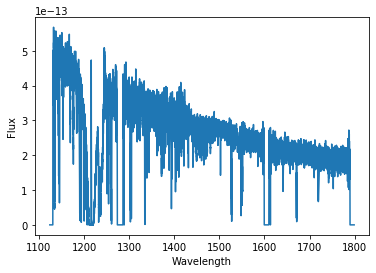

In [42]:
# %matplotlib widget

f=np.genfromtxt(filename)
W=f[:,0]
F=f[:,1]
plt.plot(W,smooth(F,5))
plt.xlabel('Wavelength')
plt.ylabel('Flux') 
# plt.ylim(-10**-13,5*10**-12)
plt.show()

In [37]:
def velocity(row,line):
    c=3e5
    v=c*(row-line)/line
    return v

In [38]:
def slice(W,F,w,dw):
    x=[]
    y=[]
    for i in range(0,len(W)):
        if W[i]>=(w-dw) and W[i]<=(w+dw):
            x.append(W[i])
            y.append(F[i])
    return x,y

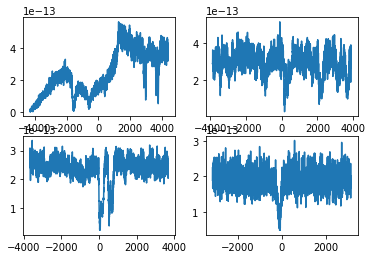

In [43]:
# %matplotlib widget

f=np.genfromtxt(filename)
W=f[:,0]
F=f[:,1]

plt.subplot(221)
w=1239
dw=18
line=1238.81
w,f=slice(W,smooth(F,1),w,dw)
vel=velocity(np.array(w),line)
plt.plot(vel,f)

plt.subplot(222)
w=1393
dw=18
line=1393
w,f=slice(W,smooth(F,1),w,dw)
vel=velocity(np.array(w),line)
plt.plot(vel,f)

plt.subplot(223)
w=1548
dw=19
line=1548
w,f=slice(W,smooth(F,1),w,dw)
vel=velocity(np.array(w),line)
plt.plot(vel,f)

plt.subplot(224)
w=1720
dw=18
line=1720
w,f=slice(W,smooth(F,1),w,dw)
vel=velocity(np.array(w),line)
plt.plot(vel,f)

plt.show()
 